# Modeling Streamflow with XGBoost

- Data source [here](https://waterdata.usgs.gov/nwis/uv?01576000)

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns

import xarray as xr
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [22]:
df = pd.read_excel('./hourly_data.xlsx')[['datetime', 'Discharge, cubic feet per second']].set_index('datetime')

In [24]:
df.rename(columns={'Discharge, cubic feet per second': 'Q'}, inplace=True)

In [26]:
df

,Q
datetime,
2018-01-01 00:00:00,12300
2018-01-01 00:30:00,12200
2018-01-01 01:00:00,12200
2018-01-01 01:30:00,12100
2018-01-01 02:00:00,12000
...,...
2022-09-05 19:30:00,5270
2022-09-05 20:00:00,5270
2022-09-05 20:30:00,5310


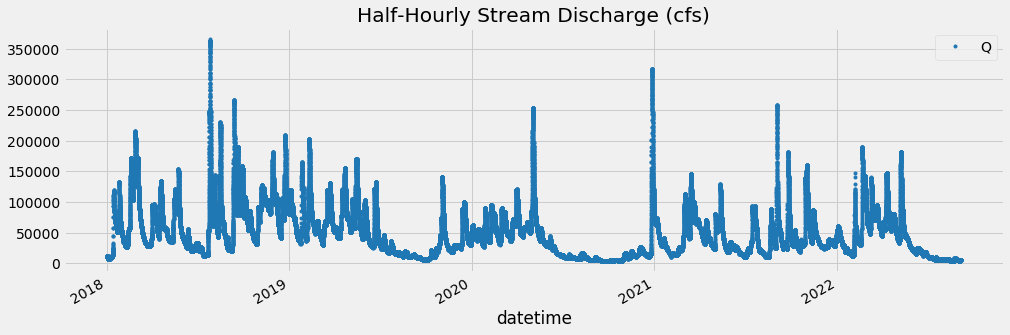

In [27]:
df.plot(style='.', 
        figsize=(15,5), 
        color=color_pal[0], 
        title='Half-Hourly Stream Discharge (cfs)')

## Splitting Up the Data

In [32]:
test_chunk = len(df)*0.8 # Training on 80% of the data
test_chunk

64083.200000000004

In [34]:
df.iloc[64083]
# 2021-10-06, 10:00:00; use 2021-10-06 as cut-off

Q    40400
Name: 2021-10-06 10:00:00, dtype: int64

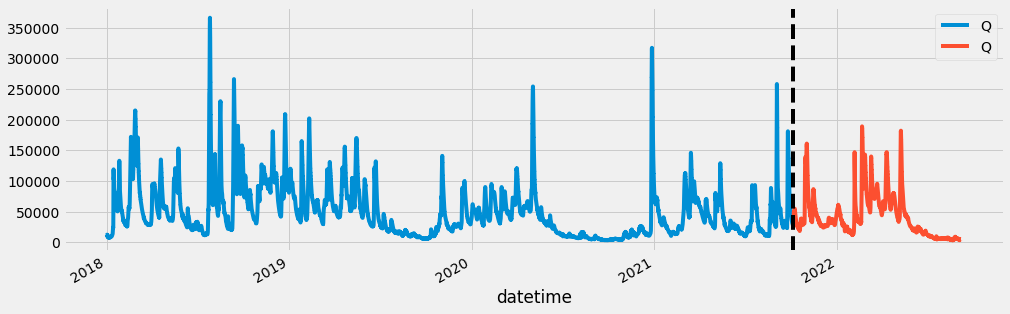

In [36]:
cutoff = '10-06-2021'

train = df.loc[df.index < cutoff]
test = df.loc[df.index >= cutoff]

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline(cutoff, color = 'k', ls='--')
plt.show()

## Feature Creation

In [37]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [39]:
df = create_features(df)
df

,Q,hour,dayofweek,quarter,month,year,dayofyear
datetime,,,,,,,
2018-01-01 00:00:00,12300,0,0,1,1,2018,1
2018-01-01 00:30:00,12200,0,0,1,1,2018,1
2018-01-01 01:00:00,12200,1,0,1,1,2018,1
2018-01-01 01:30:00,12100,1,0,1,1,2018,1
2018-01-01 02:00:00,12000,2,0,1,1,2018,1
...,...,...,...,...,...,...,...
2022-09-05 19:30:00,5270,19,0,3,9,2022,248
2022-09-05 20:00:00,5270,20,0,3,9,2022,248
2022-09-05 20:30:00,5310,20,0,3,9,2022,248


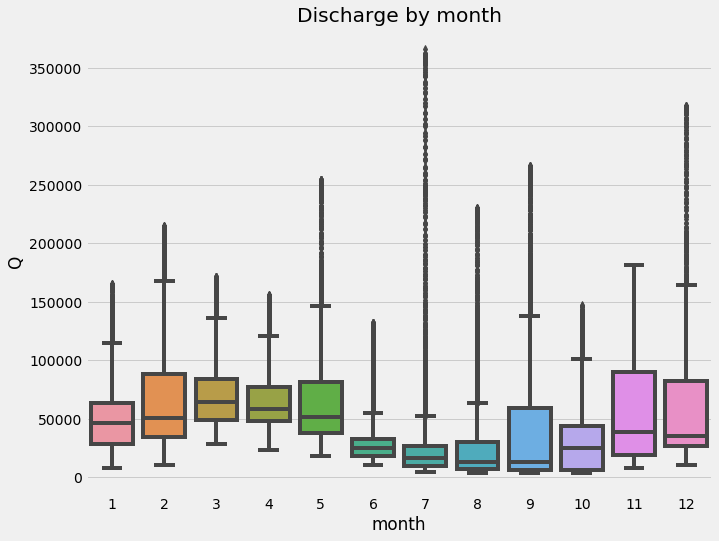

In [44]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='Q')
ax.set_title('Discharge by month')
plt.show()

## Creating the Model

In [45]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'Q'

In [46]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [48]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                      learning_rate=0.001)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[22:42:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:66259.75781	validation_1-rmse:54562.33594
[100]	validation_0-rmse:60799.06250	validation_1-rmse:50676.85156
[200]	validation_0-rmse:55909.20703	validation_1-rmse:47374.07812
[300]	validation_0-rmse:51527.20312	validation_1-rmse:44650.10938
[400]	validation_0-rmse:47547.87500	validation_1-rmse:42437.40234
[500]	validation_0-rmse:43973.85547	validation_1-rmse:40605.20703
[600]	validation_0-rmse:40793.76562	validation_1-rmse:39198.62109
[700]	validation_0-rmse:37974.87500	validation_1-rmse:38150.

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.001, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=16,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Feature Importance

In [49]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.get_booster().feature_names,
             columns=['importance'])

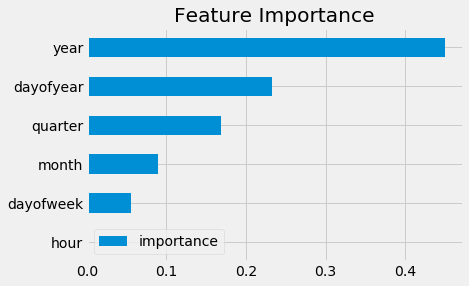

In [50]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

## Forecasting on Known Data

In [51]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

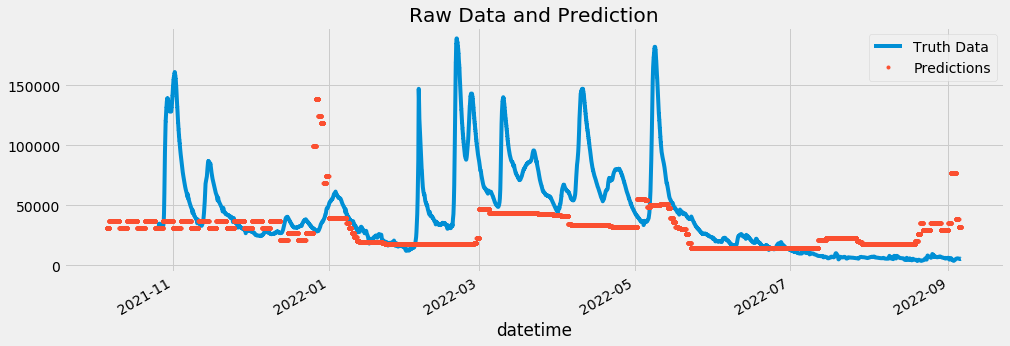

In [64]:
ax = df.loc[df.index > '10-26-2021']['Q'].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [55]:
score = np.sqrt(mean_squared_error(test['Q'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 36273.60


## Calculate Error

In [56]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [57]:
test['date'] = test.index.date

In [58]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head()

date
2022-02-20    166131.904948
2022-02-21    136673.571615
2021-11-01    125732.024740
2022-05-08    120965.462240
2022-02-26    119444.404948
Name: error, dtype: float64

In [59]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head()

date
2022-06-29    253.599284
2021-10-27    261.646322
2022-06-23    281.722819
2022-01-23    447.612793
2022-01-25    481.813965
Name: error, dtype: float64

## Conclusions

Time is not a good indicator of streamflow conditions on its own. Other factors such as precipitation should be added to understand streamflow dynamics